In [1]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import numpy as np, random, pandas as pd

data = pd.read_csv('tokenized_data.csv').dropna(subset=['tokenized_title'])
documents = [
    TaggedDocument(words=row['tokenized_title'].split(), tags=[i])
    for i, row in data.iterrows()
]
total_docs = len(documents)
print("total:", total_docs)

# traning tow Doc2Vec and save
COMMON_KWARGS = dict(vector_size=50, window=5, min_count=2,
                     workers=8, epochs=30)

model_dm   = Doc2Vec(dm=1, **COMMON_KWARGS)   # PV‑DM
model_dbow = Doc2Vec(dm=0, **COMMON_KWARGS)   # PV‑DBOW

for m in (model_dm, model_dbow):
    m.build_vocab(documents)
    m.train(documents, total_examples=m.corpus_count, epochs=m.epochs)

model_dm.save("_d2v_dm.model")
model_dbow.save("_d2v_dbow.model")

# mix vector function
def get_mix_vec(tokens):
    v_dm   = model_dm.infer_vector(tokens)
    v_dbow = model_dbow.infer_vector(tokens)
    return np.concatenate([v_dm, v_dbow])      # 100維

# leave‑one 
def evaluate_leave_one(eval_docs):
    self1, self2 = 0, 0
    total = len(eval_docs)

    corpus_vecs = [get_mix_vec(doc.words) for doc in eval_docs]

    for idx, doc in enumerate(eval_docs):
        inferred = get_mix_vec(doc.words)
        sims = np.dot(corpus_vecs, inferred) / (
            np.linalg.norm(corpus_vecs, axis=1) * np.linalg.norm(inferred) + 1e-9
        )
        top2_idx = sims.argsort()[::-1][:2]  
        if top2_idx[0] == idx:
            self1 += 1
        if idx in top2_idx:
            self2 += 1
    return self1/total, self2/total

eval_idx  = random.sample(range(total_docs), 1000)
eval_docs = [documents[i] for i in eval_idx]
top1, top2 = evaluate_leave_one(eval_docs)
print("Top‑1 self‑sim:", top1, "Top‑2 self‑sim:", top2)

total: 288321
Top‑1 self‑sim: 0.983 Top‑2 self‑sim: 0.992


Epoch 01/30  loss=0.4953  acc=0.8443
Epoch 02/30  loss=0.3863  acc=0.8721
Epoch 03/30  loss=0.3527  acc=0.8815
Epoch 04/30  loss=0.3352  acc=0.8866
Epoch 05/30  loss=0.3243  acc=0.8900
Epoch 06/30  loss=0.3166  acc=0.8924
Epoch 07/30  loss=0.3108  acc=0.8946
Epoch 08/30  loss=0.3062  acc=0.8960
Epoch 09/30  loss=0.3027  acc=0.8972
Epoch 10/30  loss=0.2995  acc=0.8983
Epoch 11/30  loss=0.2975  acc=0.8988
Epoch 12/30  loss=0.2948  acc=0.8999
Epoch 13/30  loss=0.2931  acc=0.9005
Epoch 14/30  loss=0.2912  acc=0.9010
Epoch 15/30  loss=0.2897  acc=0.9014
Epoch 16/30  loss=0.2883  acc=0.9021
Epoch 17/30  loss=0.2867  acc=0.9022
Epoch 18/30  loss=0.2859  acc=0.9026
Epoch 19/30  loss=0.2844  acc=0.9032
Epoch 20/30  loss=0.2836  acc=0.9037
Epoch 21/30  loss=0.2822  acc=0.9038
Epoch 22/30  loss=0.2814  acc=0.9039
Epoch 23/30  loss=0.2807  acc=0.9042
Epoch 24/30  loss=0.2795  acc=0.9042
Epoch 25/30  loss=0.2789  acc=0.9048
Epoch 26/30  loss=0.2782  acc=0.9051
Epoch 27/30  loss=0.2777  acc=0.9051
E

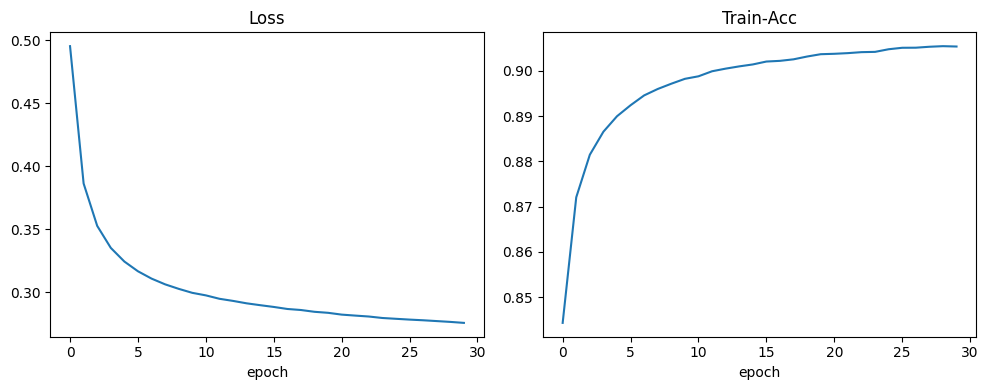

In [ ]:
import numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from gensim.models import Doc2Vec
import pandas as pd

df = pd.read_csv("tokenized_data.csv").dropna(subset=['tokenized_title', 'board'])

dm   = Doc2Vec.load("_d2v_dm.model")
dbow = Doc2Vec.load("_d2v_dbow.model")

X_vectors = [get_mix_vec(t.split()) for t in df['tokenized_title']]
y_labels  = df['board'].tolist()

label2idx = {l:i for i,l in enumerate(sorted(set(y_labels)))}
y_indices = [label2idx[l] for l in y_labels]
num_classes = len(label2idx)

#train & test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_vectors, y_indices, test_size=0.2, random_state=42, stratify=y_indices)

class VecSet(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):  return len(self.X)
    def __getitem__(self, idx):
        return (torch.tensor(self.X[idx], dtype=torch.float),
                torch.tensor(self.y[idx], dtype=torch.long))

train_loader = DataLoader(VecSet(X_tr, y_tr), batch_size=32, shuffle=True)
test_loader  = DataLoader(VecSet(X_te, y_te), batch_size=32)

#  MLP 分類器 
class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim)
        )
    def forward(self, x): return self.net(x)

model = MLP(in_dim=100, hid_dim=64, out_dim=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 30

# training 
loss_log, acc_log = [], []
for ep in range(EPOCHS):
    model.train(); tot_loss=tot=correct=0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward(); optimizer.step()
        tot_loss += loss.item()
        pred = out.argmax(1)
        correct += (pred==yb).sum().item(); tot += yb.size(0)
    loss_log.append(tot_loss/len(train_loader))
    acc_log.append(correct/tot)
    print(f"Epoch {ep+1:02}/{EPOCHS}  loss={loss_log[-1]:.4f}  acc={acc_log[-1]:.4f}")

# test 
model.eval(); tot=correct=0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb).argmax(1)
        correct += (pred==yb).sum().item(); tot += yb.size(0)
print(f" Test accuracy = {correct/tot:.4f}")

# loss & acc plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(loss_log); plt.title("Loss"); plt.xlabel("epoch")
plt.subplot(1,2,2); plt.plot(acc_log);  plt.title("Train‑Acc"); plt.xlabel("epoch")
plt.tight_layout(); plt.show()